In [1]:
#Import package pandas for data analysis
import pandas as pd

# Import package numpy for numeric computing
import numpy as np

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt

# Import PdfPages to handle creating PDFs later
from matplotlib.backends.backend_pdf import PdfPages

# Import seaborn for certain types of graphs later
import seaborn as sns

# Import preprocessing for normalising data later
from sklearn import preprocessing

# Import shuffle
from sklearn.utils import shuffle

# import test/train
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_validate

# Data understanding and preparation

#### Some assumptions:
-  Cleaned data CSV from Homework1 will be used as a starting point. 
-  I have rolled back and used the second (intermediary) cleaned CSV which still contains the -7 and -8 values (but not the -9). Based on feedback from the previous assessment, we will attempt to deal with this in a different way.


In [2]:
df = pd.read_csv("3rd_cleanedCreditRisk-18206645.csv")
df.drop('Unnamed: 0',inplace=True,axis=1)
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,NormalisedNumInqLast6Mexcl7days,NormalisedNumInstallTradesWBalance
0,1,83,176,8,70,8,0,0,100.0,-7,...,0,0,38,91,2,2,0,80,0.000000,0.370370
1,1,64,25,1,9,5,1,1,100.0,-7,...,1,1,8,-8,2,1,0,75,0.047619,0.333333
2,1,73,229,13,122,16,0,0,88.0,3,...,0,0,40,56,2,2,0,100,0.000000,0.370370
3,0,68,272,4,89,31,0,0,100.0,-7,...,0,0,90,90,8,4,4,86,0.000000,0.444444
4,1,68,147,5,76,30,2,0,72.0,40,...,3,3,48,61,4,2,1,67,0.142857,0.370370


In [3]:
print(df.shape)

(898, 26)


In [4]:
# Target feature is already encoded from the previous assignment as 0 for Good, 1 for bad.
df['RiskPerformance'].head()

0    1
1    1
2    1
3    0
4    1
Name: RiskPerformance, dtype: int64

In [5]:
descriptive_columns = df[["ExternalRiskEstimate",\
                      "PercentTradesNeverDelq",\
                      "PercentInstallTrades",\
                      "NetFractionRevolvingBurden",\
                      "NetFractionInstallBurden",\
                      "NumRevolvingTradesWBalance",\
                      "NumInstallTradesWBalance",\
                      "PercentTradesWBalance",\
                      "MSinceOldestTradeOpen",\
                      "MSinceMostRecentTradeOpen",\
                      "AverageMInFile",\
                      "NumSatisfactoryTrades",\
                      "NumTrades60Ever2DerogPubRec",\
                      "NumTrades90Ever2DerogPubRec",\
                      "MSinceMostRecentDelq",\
                      "MaxDelq2PublicRecLast12M",\
                      "NumTotalTrades",\
                      "NumTradesOpeninLast12M",\
                      "MaxDelq2PublicRecLast12M",\
                      "NumInqLast6Mexcl7days",\
                      "NumTradesOpeninLast12M",\
                      "NumInqLast6Mexcl7days"]]

descriptive_categorical = [ "MaxDelqEver",\
                            "MaxDelq2PublicRecLast12M" ]

In [6]:
# Define function to call and convert columns to categorical features
def make_categorical(dataframe):
    dataframe['MaxDelq2PublicRecLast12M'] = dataframe['MaxDelq2PublicRecLast12M'].astype("category",copy=False)
    dataframe['MaxDelqEver'] = dataframe['MaxDelqEver'].astype("category",copy=False)

In [7]:
make_categorical(df)

##### Drop the normalised columns we created at the end of the previous HW in transformation so we don't have duplicated data (models will automatically normalise these where needed).

In [8]:
df.drop('NormalisedNumInstallTradesWBalance',axis=1, inplace=True)

In [9]:
df.drop('NormalisedNumInqLast6Mexcl7days',axis=1, inplace=True)

#### New approach to dealing with -7 and -8

#### What I've done here is making some of these values binary and represent something new. While they may represent something more 'general', they will allow us to determine whether these features have an impact on the target feature (and if so, how much). For graphing, we may still use the columns with the negative values (since we can ignore these and pay attention to shape of the curves), and for the modelling we can use our new features as predictors.

In [10]:
# create column to record whether or not there are no valid/usable inquiries or trades
# such features may correlate with target feature, that's why it's useful to have these separate
df['NoValidTradesOrInqs'] = np.where(df.MSinceMostRecentDelq == -8,1,0)

In [11]:
# Useful to identify those accounts where other data may be present, but no communications
# or trades have been carried out. 
df['NoInqsOrTrades'] = np.where(df.MSinceMostRecentDelq == -7,1,0)

In [12]:
# create column for -7s in MSinceMostRecentInqexcl7days to show whether the customer has ever
# contacted us
df['HasEverContacted'] = np.where(df.MSinceMostRecentInqexcl7days == -7,1,0)

In [13]:
# Net fraction install burden is a little trickier, as it has a high percentage of trades
# unusable / not valid. This might mean these trades may have been done without extending 
# credit, or they go beyond the scope data inspection or a whole host of other reasons.
# replacing all values with the mean would skew the stats too much. Maybe the best option
# is to simply record whether there is an outstanding Install Burden or not. Making these
# binary might allow for us to determine whether or not simply having an outstanding debt
# has any sort of impact on the credit score.

df['HasOutstandingDebt'] = np.where(df.NetFractionInstallBurden == -8,1,0)

##### 1.1 Shuffle and split

In [14]:
df = shuffle(df)

In [17]:
# define the target feature
tf = df.RiskPerformance

# get a copy of our df after the shuffle with all other features we want to test excluding
# target features (these two copies are in the same order after the shuffle)
df_ex_tf = df.drop('RiskPerformance',axis=1)

In [20]:
# split train and test data
df_train, df_test, tf_train, tf_test = train_test_split(df_ex_tf, tf,test_size=0.3)

##### 1.2 Plots

In [84]:
# define the continuous columns (i.e. non-countable/int columns and non-category)
continuous_columns = df_train[[
                          "ExternalRiskEstimate",\
                          "PercentTradesNeverDelq",\
                          "PercentInstallTrades",\
                          "NetFractionRevolvingBurden",\
                          "NetFractionInstallBurden",\
                          "NumRevolvingTradesWBalance",\
                          "NumInstallTradesWBalance",\
                          "PercentTradesWBalance",\
                          "MSinceOldestTradeOpen",\
                          "MSinceMostRecentTradeOpen",\
                          "AverageMInFile",\
                          "NumSatisfactoryTrades",\
                          "NumTrades60Ever2DerogPubRec",\
                          "NumTrades90Ever2DerogPubRec",\
                          "MSinceMostRecentDelq",\
                          "NumTotalTrades",\
                          "NumTradesOpeninLast12M",\
                          "NumInqLast6Mexcl7days",\
                          "NumTradesOpeninLast12M",\
                          "NumInqLast6Mexcl7days"]].columns

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text xticklabel objects>)

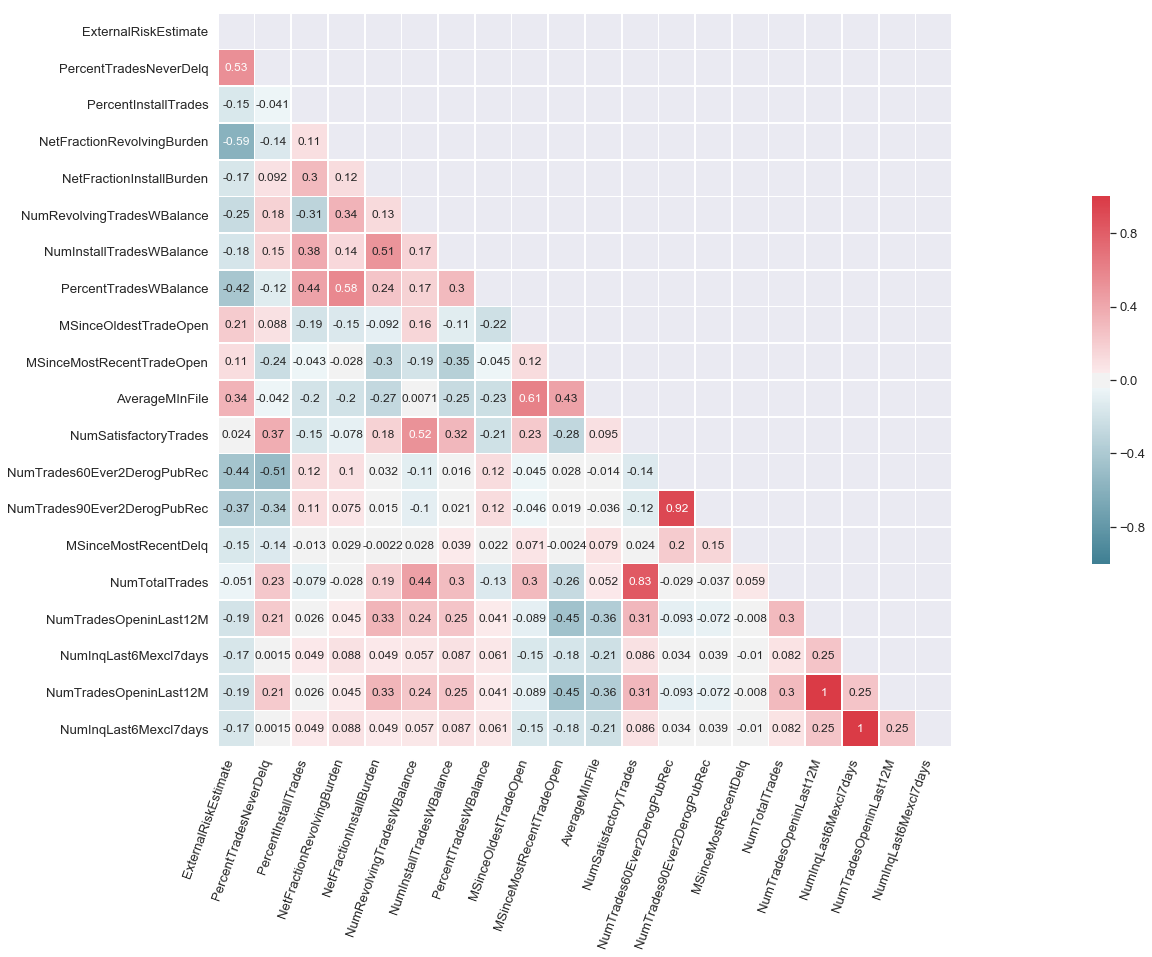

In [86]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = df_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set font size
sns.set(font_scale=1.2)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 15))

# align
f.autofmt_xdate()

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, annot_kws={"size": 12}, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.7, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 70)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

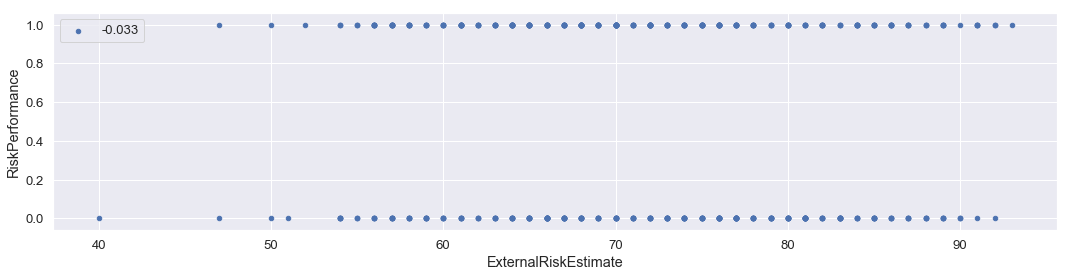

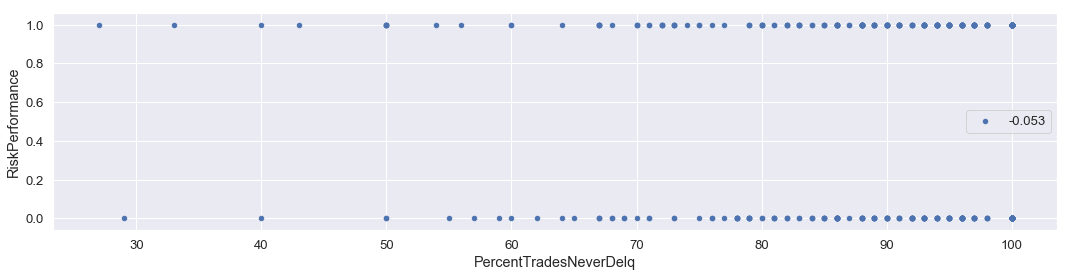

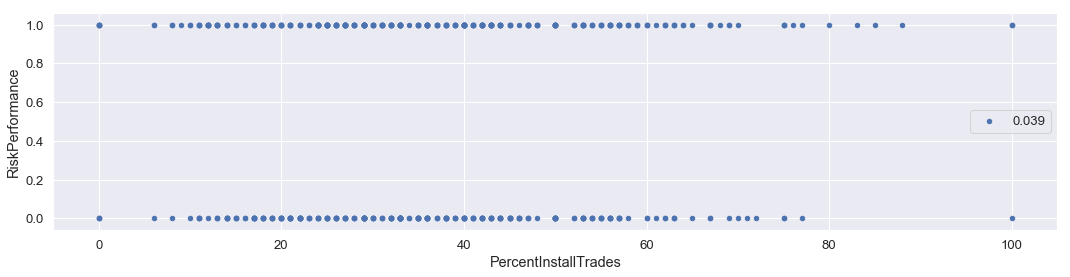

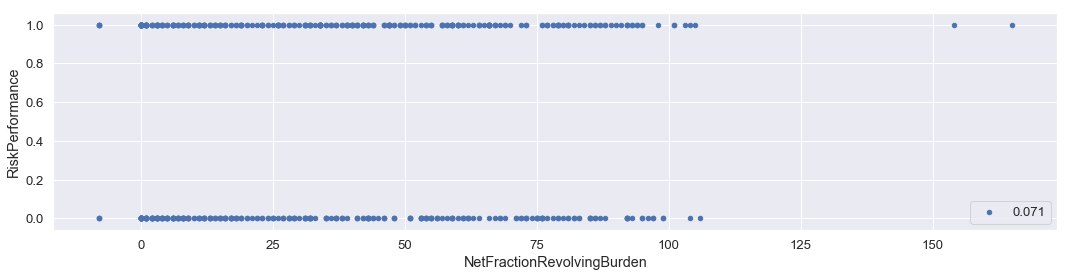

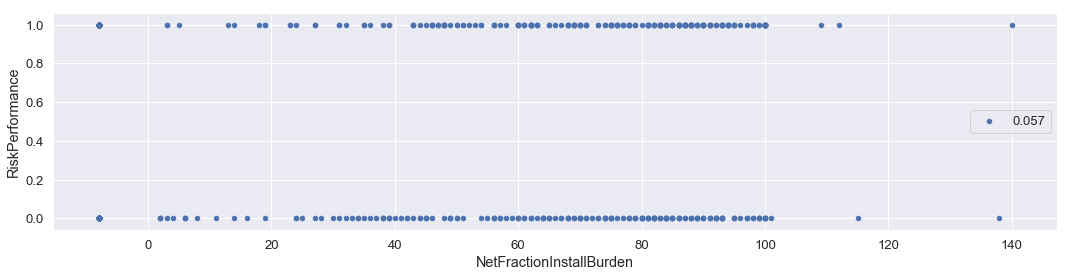

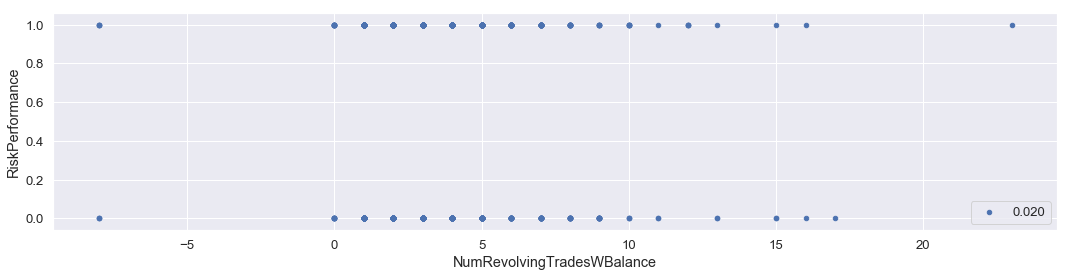

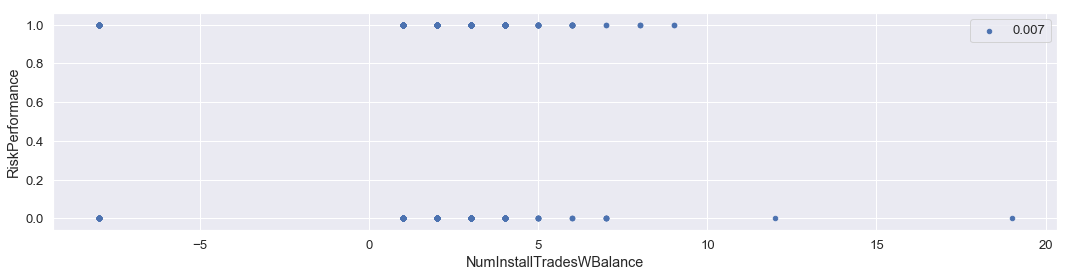

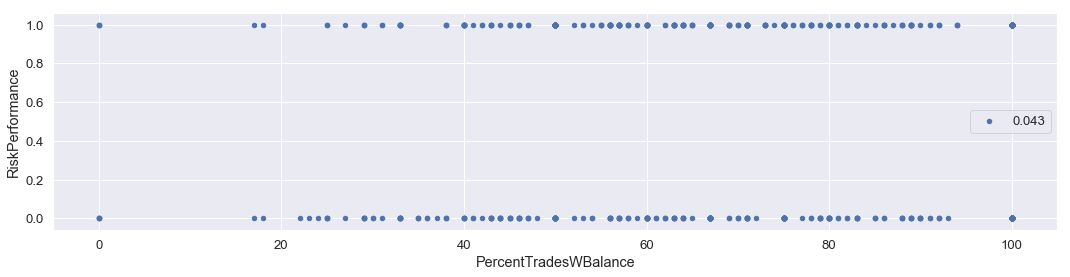

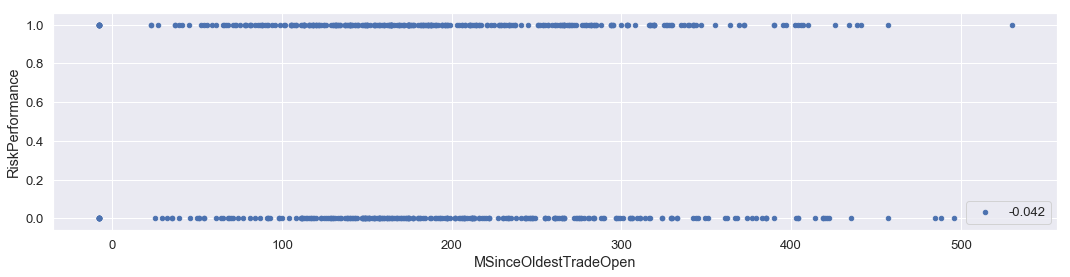

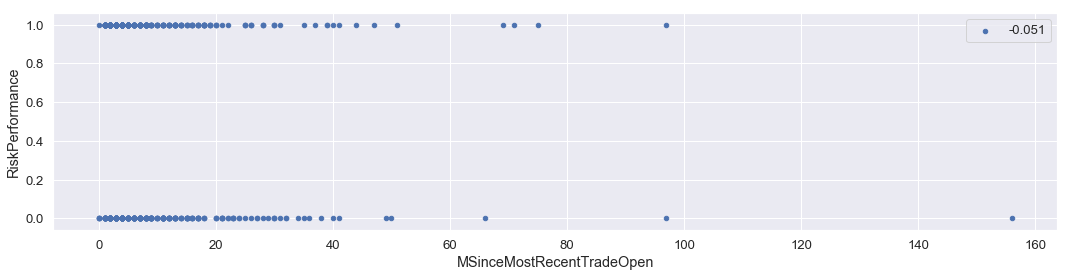

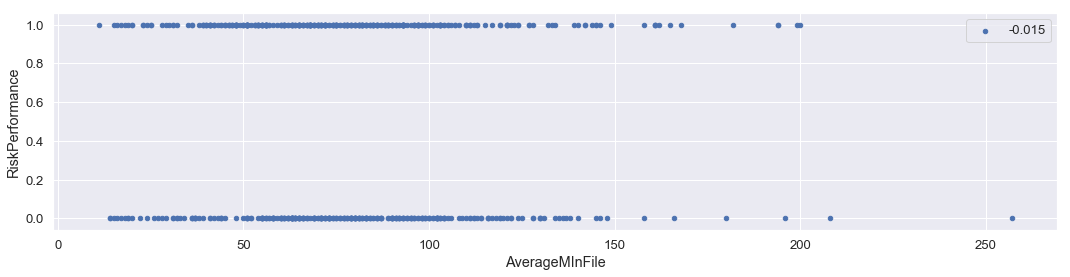

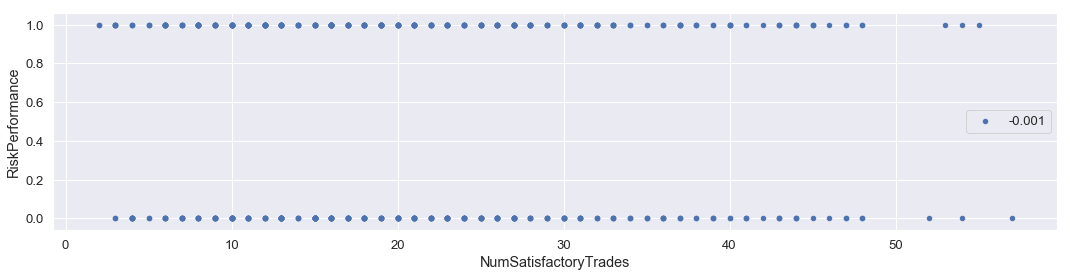

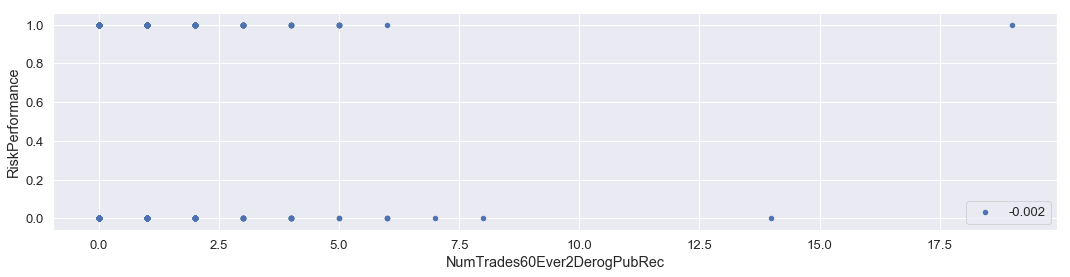

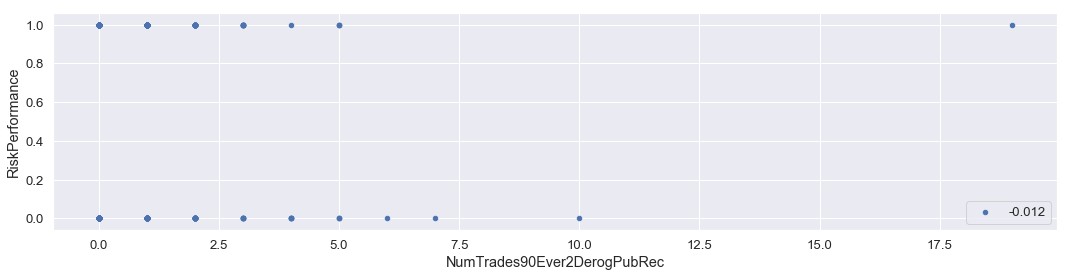

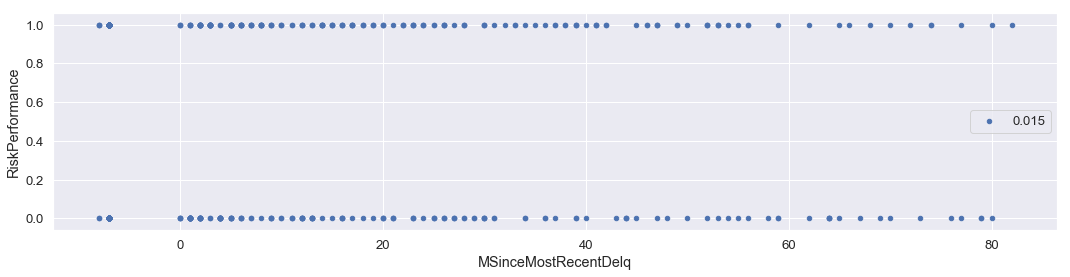

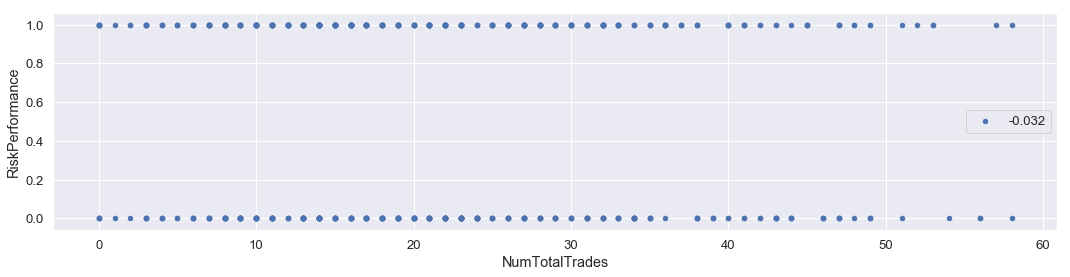

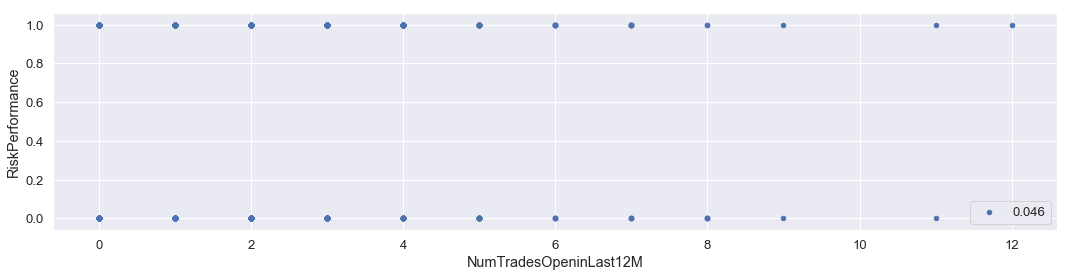

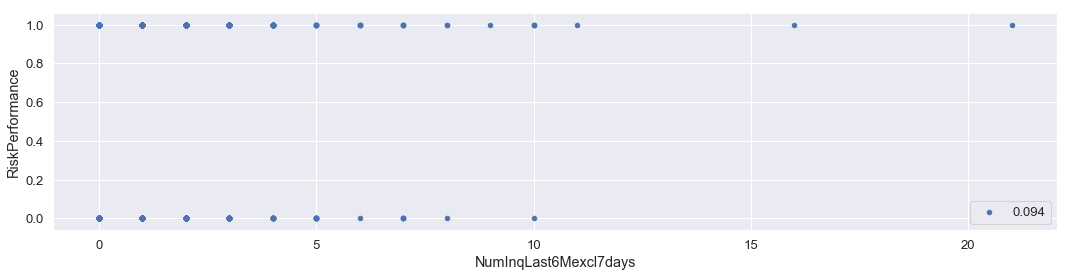

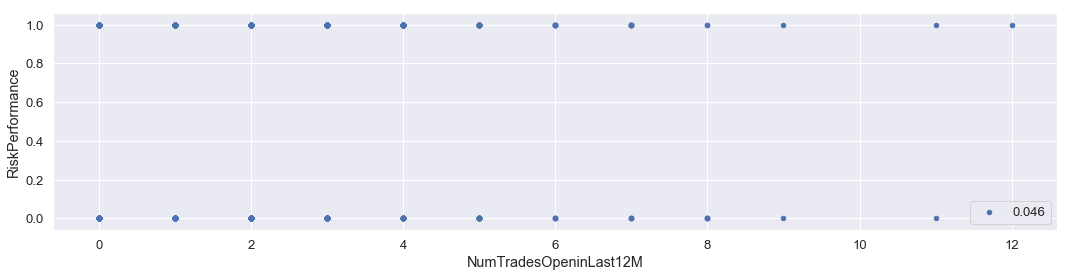

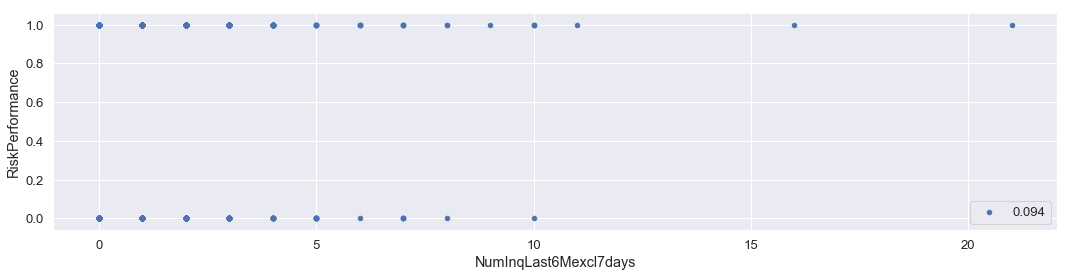

In [88]:
#concatanate train data frames for plotting
concat = pd.concat([df_train, tf_train], axis=1)
concat = concat.sort_values('RiskPerformance')

for column in continuous_columns:
    concat.plot(kind='scatter', x=column, y='RiskPerformance', label="%.3f" % concat[[column, 'RiskPerformance']].corr().values[0,1], figsize=(18, 4))

# concat.plot(kind='scatter', x='PercentTradesNeverDelq', y='RiskPerformance', label="%.3f" % concat[['PercentTradesNeverDelq', 'RiskPerformance']].corr().values[0,1], figsize=(18, 4))
# concat.plot(kind='scatter', x='PercentInstallTrades', y='RiskPerformance', label="%.3f" % concat[['PercentInstallTrades', 'RiskPerformance']].corr().values[0,1], figsize=(18, 4))
# concat.plot(kind='scatter', x='NetFractionRevolvingBurden', y='RiskPerformance', label="%.3f" % concat[['NetFractionRevolvingBurden', 'RiskPerformance']].corr().values[0,1], figsize=(18, 4))
# concat.plot(kind='scatter', x='NetFractionInstallBurden', y='RiskPerformance', label="%.3f" % concat[['NetFractionInstallBurden', 'RiskPerformance']].corr().values[0,1], figsize=(18, 4))
# concat.plot(kind='scatter', x='PercentTradesWBalance', y='RiskPerformance', label="%.3f" % concat[['PercentTradesWBalance', 'RiskPerformance']].corr().values[0,1], figsize=(18, 4))

In [76]:
binary_columns = df_train[[
                      "HasOutstandingDebt",\
                      "HasEverContacted",\
                      "NoInqsOrTrades",\
                      "NoValidTradesOrInqs"]].columns

In [89]:
for column in binary_columns:
    concat['RiskPerformance'].hist(by=concat[column], figsize=(10,5), bins=2)

AttributeError: 'Series' object has no attribute 'bar'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E8A247DB70>,
      dtype=object)

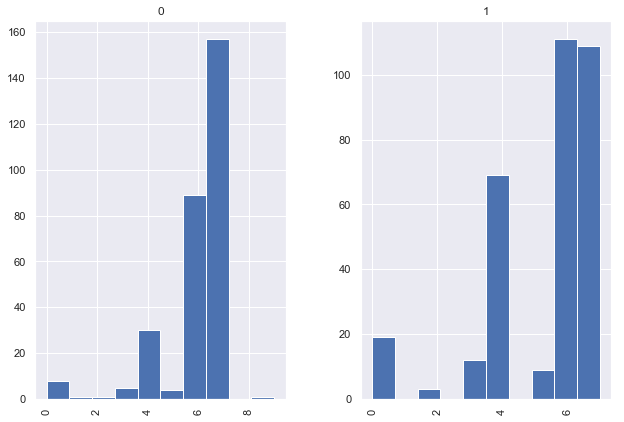

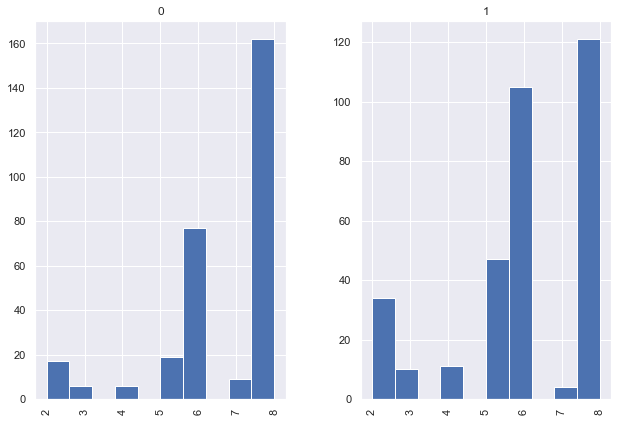

In [83]:
categorical_columns_non_binary = df_train[[
                      "MaxDelq2PublicRecLast12M",\
                      "MaxDelqEver"]].columns

concat['MaxDelq2PublicRecLast12M'].hist(by=concat['RiskPerformance'], figsize=(10,7), bins=10)
concat['MaxDelqEver'].hist(by=concat['RiskPerformance'], figsize=(10,7), bins=10)